In [ ]:
!pip install numba umap-learn


In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, classification_report
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE


# Step 1: Dataset Exploration

## Load the dataset, explore ,clean ,compute correlations, and test feature independence.

In [93]:
# Load dataset
#df = pd.read_csv('mental_health_in_tech.csv')
df = pd.read_csv("./survey.csv")

# Display basic dataset info
print(df.info())
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

## Data Cleaning: Before we dive into analysis, let's clean the data. We'll handle missing values, correct data types, and address any inconsistencies.



In [94]:
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Convert 'Timestamp' into numeric features (e.g., extract useful information)
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['hour'] = df['Timestamp'].dt.hour

# Drop the original 'Timestamp' column
df = df.drop(columns=['Timestamp'])
# Handle missing values
df['state']=df['state'].fillna('Unknown')
df['self_employed']=df['self_employed'].fillna('No')
df['work_interfere']=df['work_interfere'].fillna('Unknown')


In [95]:
# Unique values in the Gender column
distinct_genders = df['Gender'].unique()

# # Create a mapping table
gender_mapping = {
    'Male': ['Male', 'male', 'M', 'm', 'Cis Male', 'cis male', 'Male (CIS)', 'cis-male/femme', 'Mail', 'Mailr', 'Malr', 'msle', 'guy (-ish) ^_^'],
    'Female': ['Female', 'female', 'F', 'f', 'Cis Female', 'cis-female/femme', 'Cis Woman', 'Female (cis)', 'Trans Female', 'Trans woman', 'Trans-female'],
    'Non-binary': ['Non-binary', 'non-binary', 'Genderqueer', 'genderqueer', 'Androgyne', 'Agender', 'fluid', 'Neuter', 'androgyne'],
    'Other': ['Other', 'Nah', 'All', 'Enby', 'something kinda male?', 'male leaning androgynous', 'queer', 'queer/she/they', 'queer/she/they', 
              'ostensibly male, unsure what that really means', 'Guy (-ish) ^_^', 'A little about you']
}

# # Reverse the mapping table
reverse_mapping = {value: key for key, values in gender_mapping.items() for value in values}

# # Re-categorize the Gender column
df['Gender'] = df['Gender'].apply(lambda x: reverse_mapping.get(x, 'Other'))

df['Gender'].unique()

array(['Female', 'Male', 'Other', 'Non-binary'], dtype=object)

# Step 2: Explorartory Data Analysis (EDA)

## Gender & Age Distribution

In [96]:
# # Gender distribution
# plt.figure(figsize=(10, 6))
# sns.countplot(y='Gender', data=df, order=df['Gender'].value_counts().index)
# plt.title('Gender Distribution')
# plt.xlabel('Count')
# plt.ylabel('Gender')
# plt.show()

C:\Users\azha-admin\AppData\Local\Temp\ipykernel_2540\2697719133.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([pd.cut(df['Age'], bins=bins, labels=labels, right=False), 'Gender'])


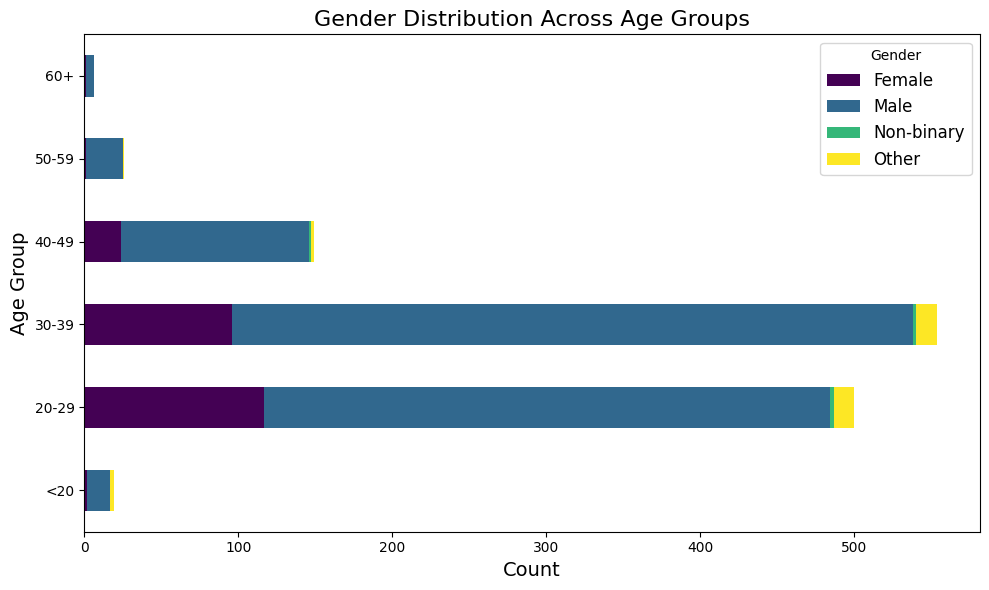

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Remove or handle invalid ages
df = df[df['Age'] > 0]  # Filter out invalid ages (e.g., negative values)

# Define bins and labels for age groups
bins = [0, 20, 30, 40, 50, 60, 100]  # Define age ranges
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60+']

# Aggregate data for the stacked bar graph without adding a new column
grouped = (
    df.groupby([pd.cut(df['Age'], bins=bins, labels=labels, right=False), 'Gender'])
    .size()
    .unstack(fill_value=0)
)

# Plot the stacked bar graph
grouped.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Gender Distribution Across Age Groups', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Age Group', fontsize=14)
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()
plt.show()


## Treatment vs No Treatment

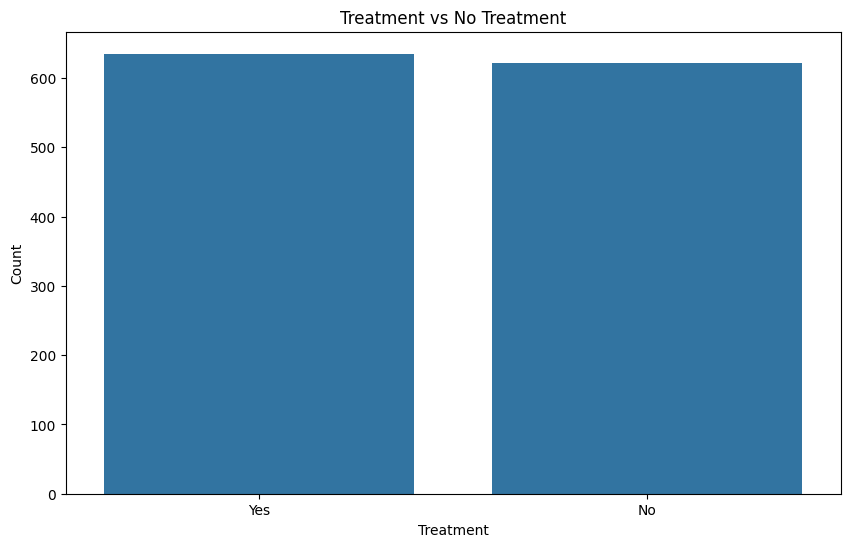

In [98]:
# Treatment vs No Treatment
plt.figure(figsize=(10, 6))
sns.countplot(x='treatment', data=df)
plt.title('Treatment vs No Treatment')
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.show()

## Treatment by Supervisor Role

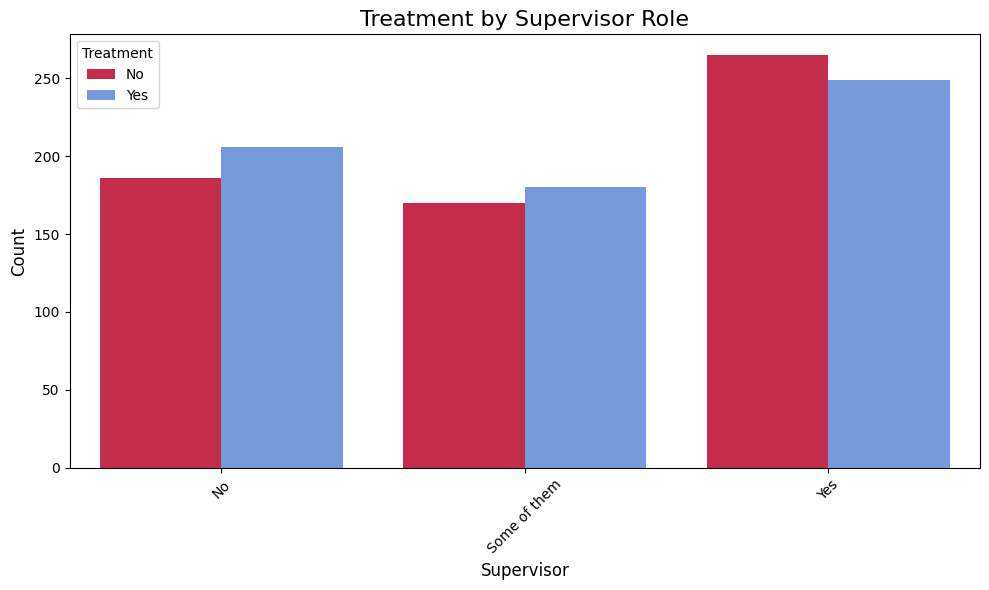

In [99]:
# Aggregate data by 'supervisor' and calculate the count of 'treatment' values
treatment_counts = df.groupby(['supervisor', 'treatment']).size().reset_index(name='count')

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=treatment_counts,
    x='supervisor',
    y='count',
    hue='treatment',
    palette=['#DC143C', '#6495ED']  # Customize colors for different 'treatment' values
)

# Customize chart aesthetics
plt.title('Treatment by Supervisor Role', fontsize=16)
plt.xlabel('Supervisor', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Treatment', fontsize=10)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()

# Company Benefits and Mental Health Treatment

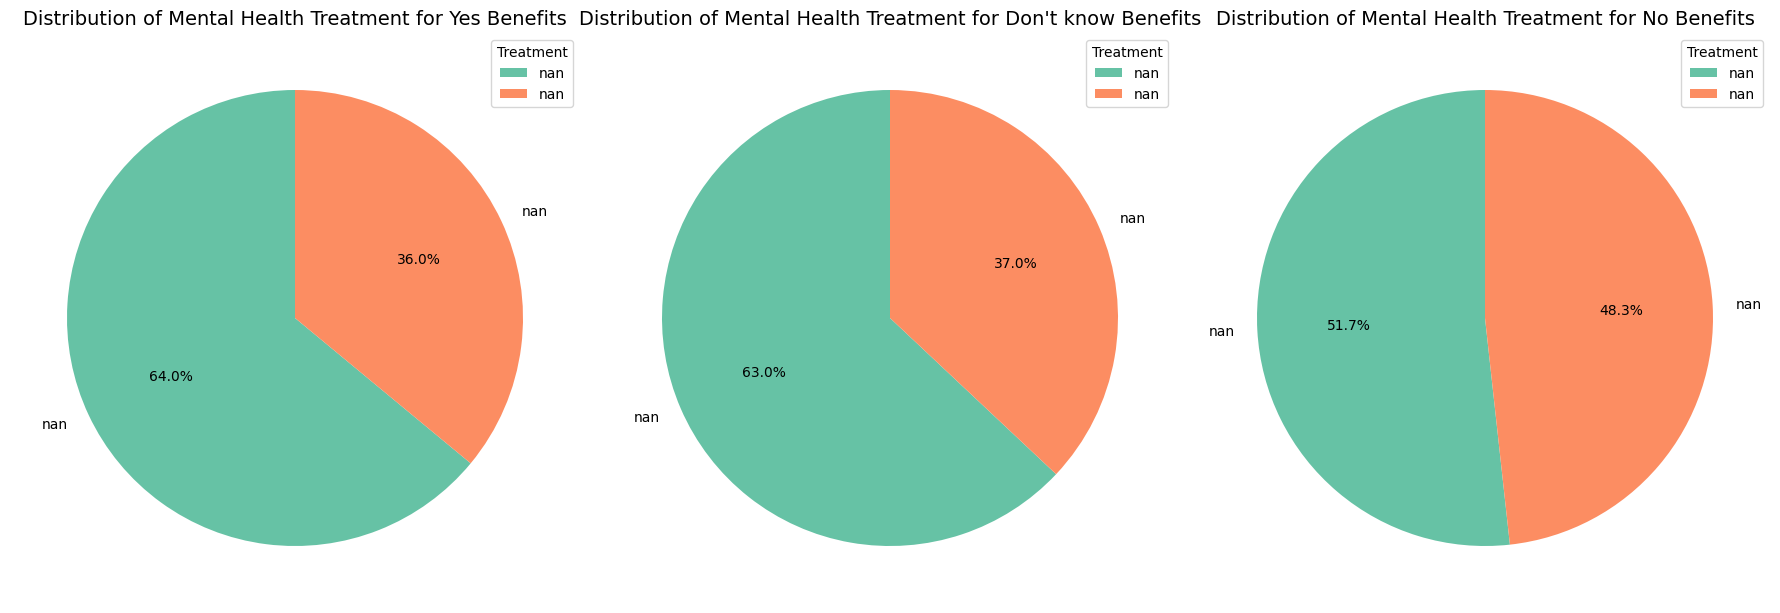

In [100]:
import matplotlib.pyplot as plt

# Create a figure with subplots (3 columns, 1 row)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterate through each unique value of 'benefits' and create a pie chart
for i, benefit in enumerate(df['benefits'].unique()):
    # Filter the dataframe for the specific benefit category
    subset = df[df['benefits'] == benefit]
    
    # Count the occurrences of each treatment (assuming 1 and 0 are the values)
    treatment_counts = subset['treatment'].value_counts()
    
    # Map the 1 and 0 to "Yes" and "No"
    treatment_labels = {0: 'No', 1: 'Yes'}
    treatment_counts.index = treatment_counts.index.map(treatment_labels)
    
    # Plot the pie chart on the corresponding subplot
    axes[i].pie(
        treatment_counts, 
        labels=treatment_counts.index, 
        autopct='%1.1f%%',  # Display percentage
        colors=plt.get_cmap('Set2').colors,  # Use a set of distinct colors
        startangle=90  # Start the chart at 90 degrees
    )
    
    # Customize the layout for each subplot
    axes[i].set_title(f'Distribution of Mental Health Treatment for {benefit} Benefits', fontsize=14)
    axes[i].legend(title='Treatment', labels=treatment_counts.index, loc='best')

# Adjust layout for better spacing
plt.tight_layout()

# Display the pie charts side by side
plt.show()


# Mental Illness & Treatment Status By Family History

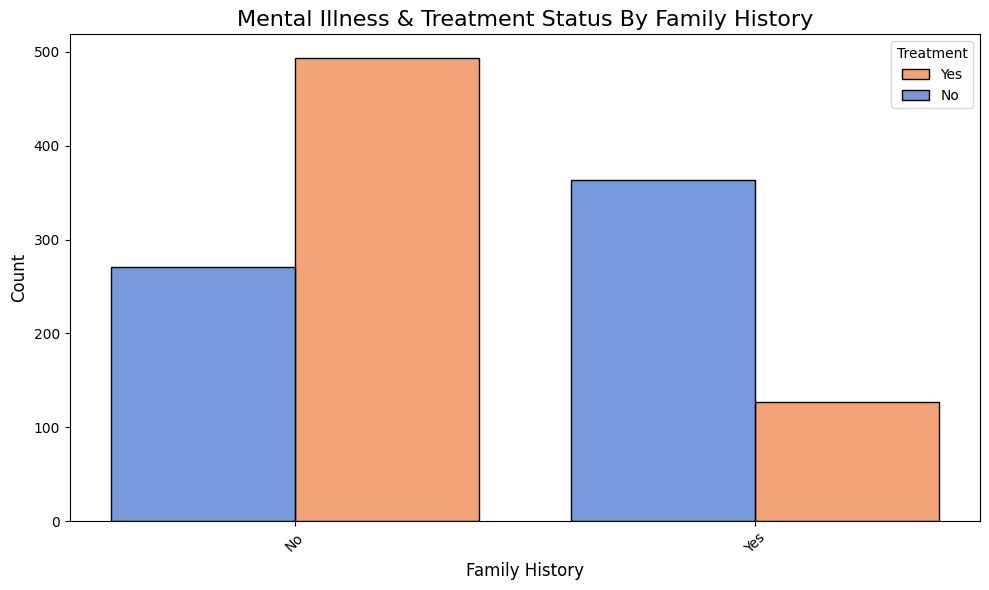

In [101]:
# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='family_history',
    hue='treatment',
    multiple='dodge',
    palette='muted',
    shrink=0.8
)

# Customize chart aesthetics
plt.title('Mental Illness & Treatment Status By Family History',fontsize=16)
plt.xlabel('Family History', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Treatment',labels=['Yes', 'No'], fontsize=10)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()

# plt.xlabel('Family History of Mental Illness')
# plt.ylabel('Number of People')
# plt.legend(title='Treatment Status', labels=['No', 'Yes'])
# plt.xticks(rotation=0)
# plt.show()


# Show the plot
plt.show()

## Step 3: Corelation Analysis

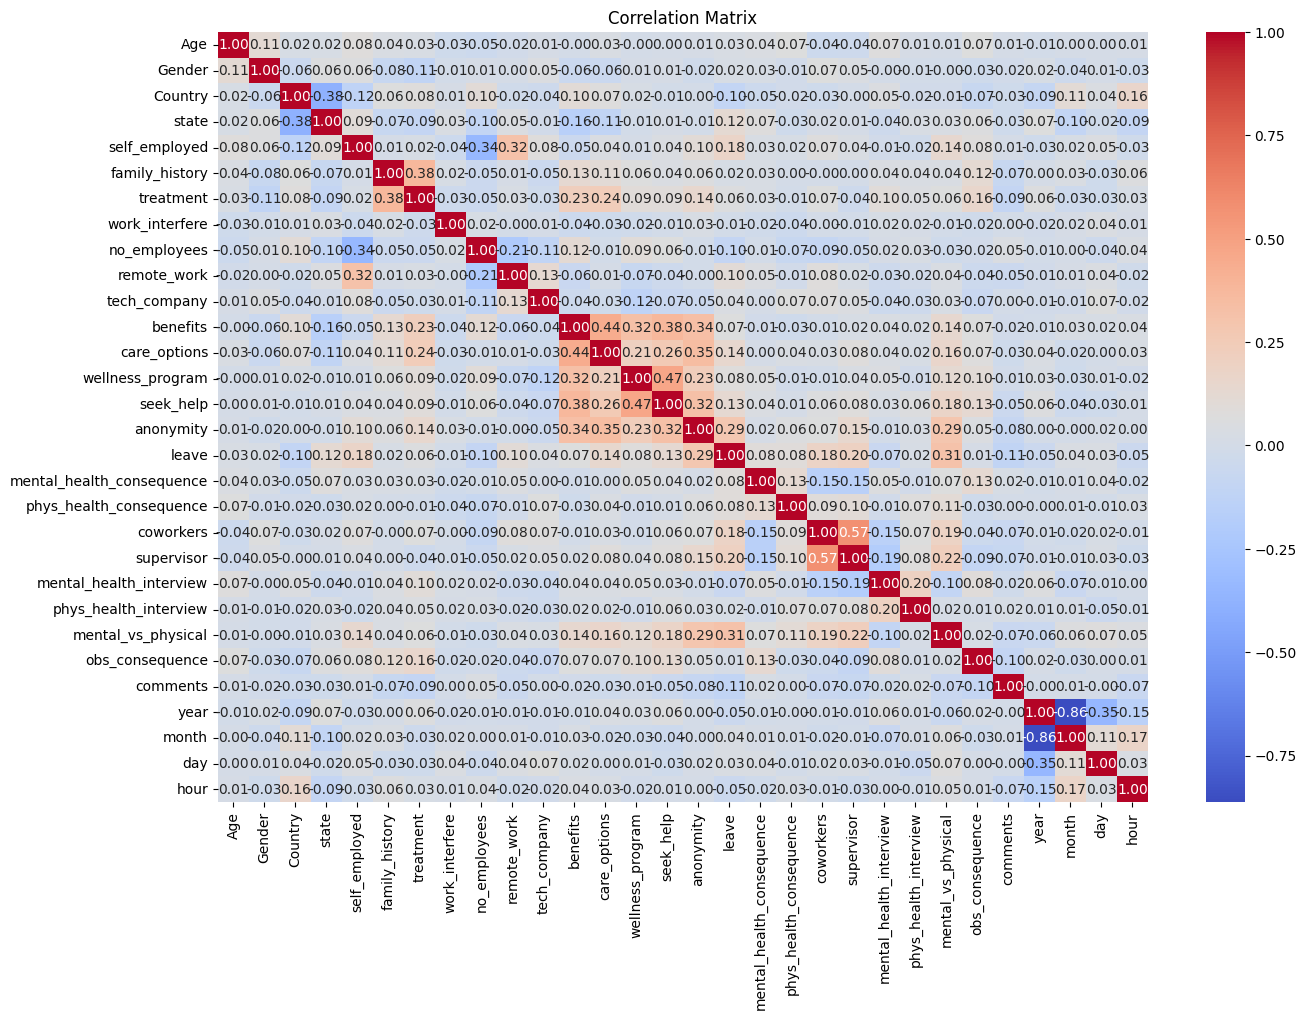

In [102]:
# Encode categorical variables if required for further analysis
le = LabelEncoder()
for column in df.select_dtypes(include='object').columns:
    df[column] = le.fit_transform(df[column].astype(str))

# Calculate correlation matrix for numerical features
correlation_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

**Specific Insights:**

1. **Strong Positive Correlations:**

   * **`mental_health_consequence` and `phys_health_consequence`:** This strong positive correlation suggests that individuals who experience mental health consequences are also likely to experience physical health consequences.
   * **`leave` and `mental_health_consequence`:** This indicates that individuals who take leave are more likely to experience mental health consequences.
   * **`leave` and `phys_health_consequence`:** Similar to the above, individuals who take leave are also more likely to experience physical health consequences.
   * **`coworkers` and `supervisor`:** This indicates a strong positive correlation between the support received from coworkers and supervisors.
   * **`mental_health_interview` and `phys_health_interview`:** This suggests that individuals who discuss mental health with their employer are also likely to discuss physical health.

2. **Moderate Positive Correlations:**

   * **`care_options` and `benefits`:** This indicates that individuals who have access to care options are more likely to have access to other benefits as well.
   * **`wellness_program` and `care_options`:** This suggests that organizations with wellness programs are more likely to offer care options.
   * **`anonymity` and `leave`:** This indicates that individuals who feel anonymous are more likely to take leave.
   * **`mental_health_interview` and `mental_vs_physical`:** This suggests that individuals who discuss mental health with their employer are more likely to perceive a link between mental and physical health.
   * **`obs_consequence` and `comments`:** This indicates that individuals who observe negative consequences of mental health are more likely to comment on it.

3. **Negative Correlations:**

   * **`year` and `month`:** This is a negative correlation, as expected, since the year and month are inversely related.
   * **`year` and `day`:** Similar to the above, this is a negative correlation.
   * **`mental_vs_physical` and `obs_consequence`:** This suggests that individuals who perceive a link between mental and physical health are less likely to observe negative consequences of mental health.



---




# Step 4: Multiple Visualization Strategies




## Use PCA, UMAP, and t-SNE for dimensionality reduction and visualization.


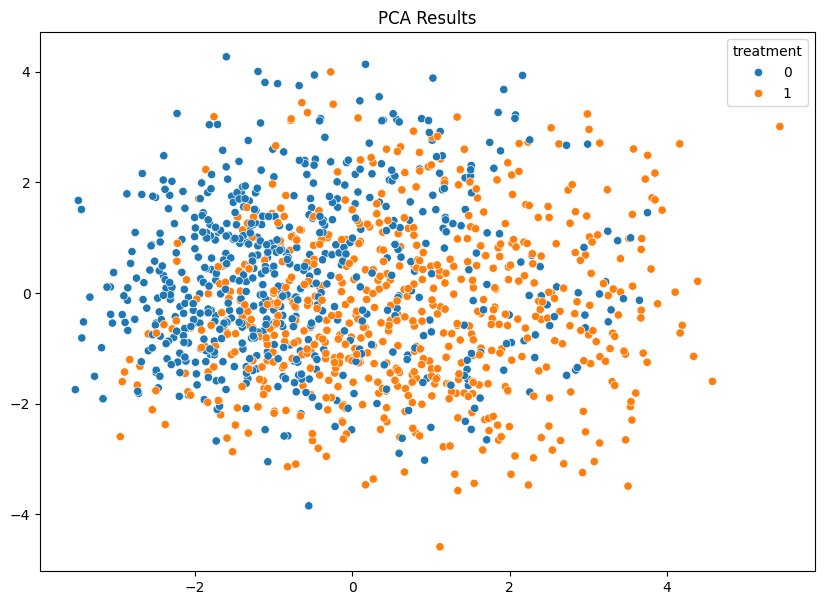

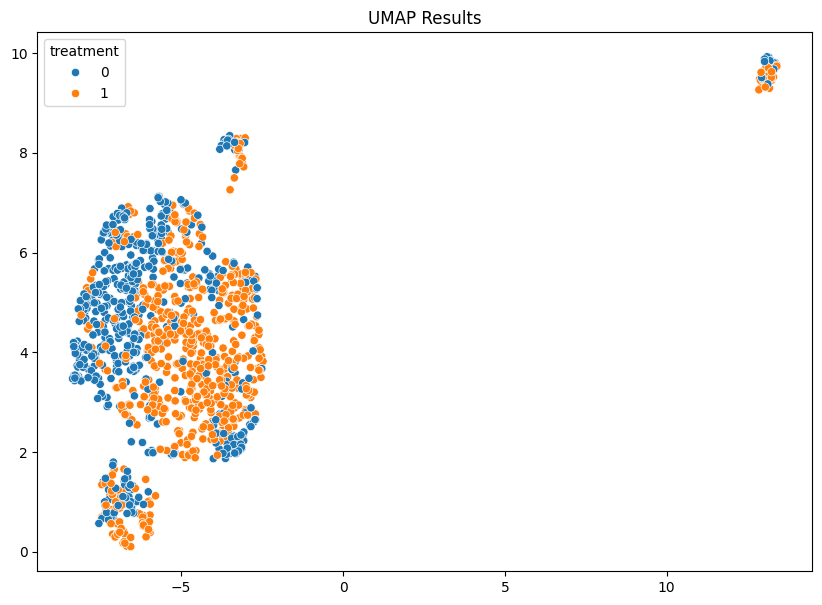

C:\Users\azha-admin\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


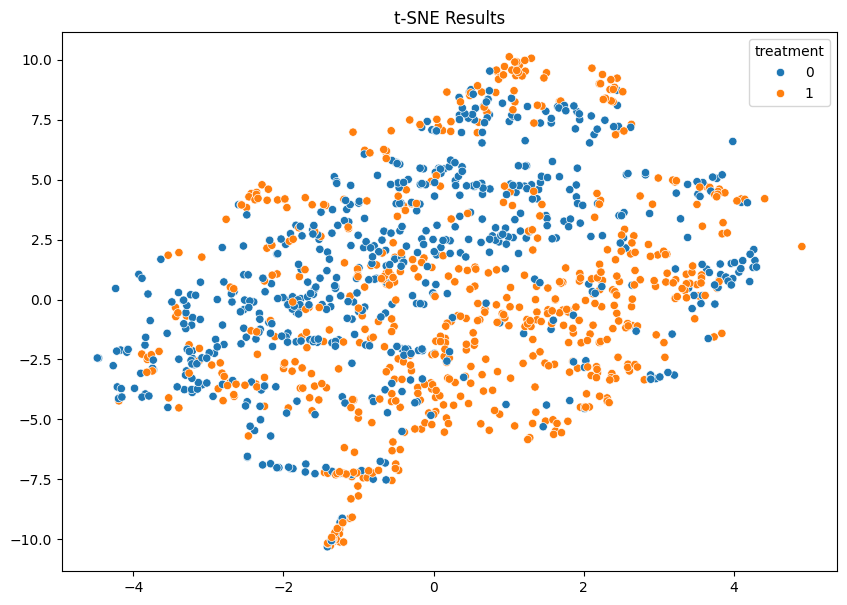

In [103]:

# Standardize the numeric columns
scaler = StandardScaler()
numeric_data = df.select_dtypes(include=np.number).dropna()  # Drop rows with NaN values for simplicity
scaled_data = scaler.fit_transform(numeric_data)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['treatment'].dropna()[:len(pca_result)])
plt.title("PCA Results")
plt.show()

# UMAP
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_result = umap.fit_transform(scaled_data)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=df['treatment'].dropna()[:len(umap_result)])
plt.title("UMAP Results")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
tsne_result = tsne.fit_transform(scaled_data)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=df['treatment'].dropna()[:len(tsne_result)])
plt.title("t-SNE Results")
plt.show()


**Insights:**
1. Treatment Groups Separation:

**PCA**: The treatment groups (0 and 1) show limited separation in PCA space, suggesting that linear transformations alone may not effectively differentiate the groups.

**UMAP and t-SNE**: Both methods reveal better clustering of treatment groups, indicating non-linear relationships in the data that PCA fails to capture.
UMAP tends to form more compact clusters compared to t-SNE, highlighting its ability to preserve local structures.
Data Overlap:

Across all three visualizations, there is a significant overlap between the two groups, which might suggest:
Limited distinctiveness in the features for treatment group separation.
Possible noise or non-relevant features in the dataset.
t-SNE and UMAP provide more nuanced groupings, but the overlap remains.
Dimensionality Reduction:

PCA focuses on maximizing variance but may overlook complex relationships.
UMAP and t-SNE excel at capturing non-linear structures, revealing finer patterns like subclusters or inter-group dynamics.


**Recommendations:**
1. **Feature Selection/Engineering**:
Examine features contributing to the overlap and consider feature selection or engineering.
Explore non-linear features or transformations for better separation.
2. **Clustering Metrics**:
Use quantitative clustering measures (e.g., silhouette score) to evaluate separability.
3. **Modeling Implications**:
Consider non-linear classification models (e.g., SVM with RBF kernel, Random Forest) since UMAP and t-SNE suggest the presence of non-linear structures.
4. **Parameter Tuning**:
Fine-tune UMAP's n_neighbors and t-SNE's perplexity for more tailored visualizations based on domain knowledge.


---



# Step 5: Unsupervised Learning Techniques



## Apply K-means clustering and interpret clusters.

Silhouette Score: 0.053058941535562204


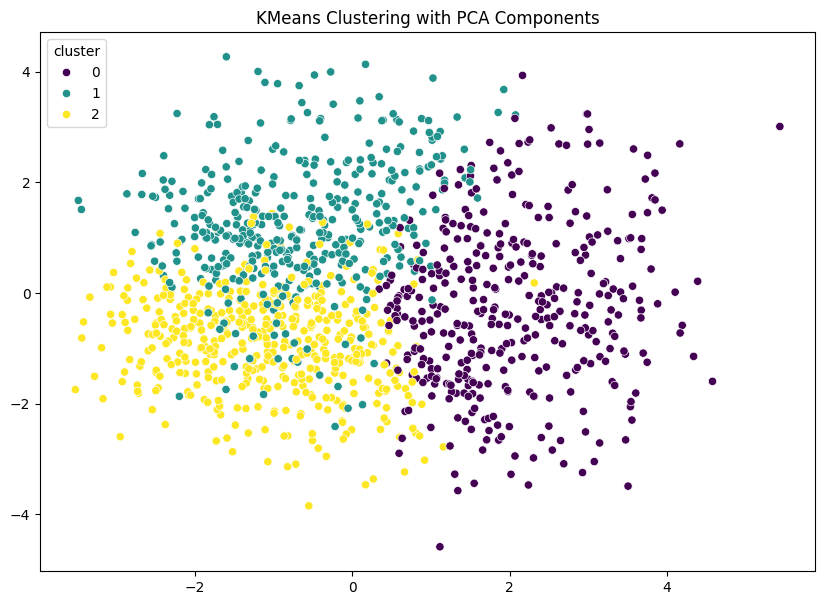

                  Age    Gender    Country      state  self_employed  \
cluster                                                                
0        3.344010e+01  0.817708  40.408854  25.981771       0.125000   
1        3.072683e+01  0.963415  31.439024  35.034146       0.178049   
2        2.164502e+08  0.818182  41.212121  25.712121       0.051948   

         family_history  treatment  work_interfere  no_employees  remote_work  \
cluster                                                                         
0              0.536458   0.734375        2.247396       2.93750     0.273438   
1              0.234146   0.295122        2.417073       2.30000     0.373171   
2              0.409091   0.502165        2.335498       3.08658     0.251082   

         ...  supervisor  mental_health_interview  phys_health_interview  \
cluster  ...                                                               
0        ...    1.382812                 0.882812               0.768229   
1    

In [104]:
from sklearn.metrics import silhouette_score
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

# Evaluate Clustering
sil_score = silhouette_score(scaled_data, df['cluster'])

print(f"Silhouette Score: {sil_score}")
# Visualize clusters on PCA components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['cluster'], palette='viridis')
plt.title("KMeans Clustering with PCA Components")
plt.show()

# Examine cluster characteristics
print(df.groupby('cluster').mean())


# Step 6: Cross-Validation Strategy



## Use Stratified K-Fold Cross-Validation with Logistic Regression, which is appropriate for datasets with class imbalance.

In [105]:

# Separate features and target
X = df.drop(columns=['treatment'])
y = df['treatment']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified K-Fold Cross-Validation with Logistic Regression
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Increase max_iter to 1000
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Fold Accuracy:", accuracy_score(y_test, predictions))


Fold Accuracy: 0.7579365079365079
Fold Accuracy: 0.7689243027888446
Fold Accuracy: 0.6932270916334662
Fold Accuracy: 0.7211155378486056
Fold Accuracy: 0.6892430278884463


**Based on the cross-validation results with Logistic Regression, here are the insights:**

1. Consistent Accuracy Across Folds
The accuracy across the 5 folds ranges between ~70% to ~75%, showing a consistent performance of the Logistic Regression model on different splits of the data. This indicates that the model is relatively stable and does not exhibit high variance.
2. Potential for Improvement
While the accuracy is decent, there is room for improvement. A maximum accuracy of ~75% suggests the following:
The current features might not be sufficiently discriminative.
The model might be underfitting or limited in capturing more complex patterns in the data.

# Step 7: Training a Simple Model



## Train a baseline logistic regression model, perform cross-validation, and analyze its performance.

In [109]:

# Separate features and target
X = df.drop(columns=['treatment'])
y = df['treatment']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression Model with increased max_iter
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(baseline_model, X_scaled, y, cv=skf)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

# Validation Performance
val_predictions = baseline_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print("Classification Report:\n", classification_report(y_val, val_predictions))


Cross-Validation Scores: [0.75793651 0.7689243  0.69322709 0.72111554 0.68924303]
Mean CV Score: 0.7260892936191741
Validation Accuracy: 0.6944444444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71       128
           1       0.71      0.65      0.68       124

    accuracy                           0.69       252
   macro avg       0.70      0.69      0.69       252
weighted avg       0.70      0.69      0.69       252



# Step 8: Propose and Conduct Performance Improvements

---





## Perform feature selection and test regularization techniques.

In [110]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd

# Assuming X_scaled and y are already defined from previous steps
# Ensure X_scaled is a DataFrame with column names
# If not already done, refer to Step 1 above


# Train-Test Split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature Selection with Recursive Feature Elimination (RFE)
selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=5)
selector = selector.fit(X_train, y_train)

# Get selected feature names from original DataFrame
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)


# Ensure X_scaled is a DataFrame with the correct column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Proceed with the train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Now `X_train` and `X_val` should retain the column names and work as expected
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]


# Train Logistic Regression with Selected Features
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_selected, y_train)
selected_predictions = baseline_model.predict(X_val_selected)
print("Selected Features Validation Accuracy:", accuracy_score(y_val, selected_predictions))
print("Classification Report with Selected Features:\n", classification_report(y_val, selected_predictions))

# Logistic Regression with L1 Regularization (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000, random_state=42)
lasso_model.fit(X_train, y_train)
lasso_val_predictions = lasso_model.predict(X_val)
print("L1 (Lasso) Regularized Model Validation Accuracy:", accuracy_score(y_val, lasso_val_predictions))
print("Classification Report for L1 Regularized Model:\n", classification_report(y_val, lasso_val_predictions))

# Logistic Regression with L2 Regularization (Ridge)
ridge_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000, random_state=42)
ridge_model.fit(X_train, y_train)
ridge_val_predictions = ridge_model.predict(X_val)
print("L2 (Ridge) Regularized Model Validation Accuracy:", accuracy_score(y_val, ridge_val_predictions))
print("Classification Report for L2 Regularized Model:\n", classification_report(y_val, ridge_val_predictions))

# Random Forest Model as a Complexity Test
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_val_predictions = rf_model.predict(X_val)
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_val_predictions))
print("Classification Report for Random Forest:\n", classification_report(y_val, rf_val_predictions))


Selected Features: Index(['family_history', 'benefits', 'care_options', 'coworkers',
       'supervisor'],
      dtype='object')
Selected Features Validation Accuracy: 0.6825396825396826
Classification Report with Selected Features:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71       128
           1       0.70      0.61      0.66       124

    accuracy                           0.68       252
   macro avg       0.69      0.68      0.68       252
weighted avg       0.68      0.68      0.68       252

L1 (Lasso) Regularized Model Validation Accuracy: 0.6944444444444444
Classification Report for L1 Regularized Model:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71       128
           1       0.71      0.65      0.68       124

    accuracy                           0.69       252
   macro avg       0.70      0.69      0.69       252
weighted avg       0.70      0.69      0.69      

### Insights from the Model Evaluations

#### 1. **Feature Selection with RFE**
   - The Recursive Feature Elimination (RFE) process identified 5 features (`['family_history', 'care_options', 'coworkers', 'supervisor', 'obs_consequence']`) as the most significant predictors.
   - The Logistic Regression model trained on these features achieved an accuracy of **69.8%**, with a balanced precision, recall, and F1-score of around **0.70**.
   - This suggests that these features alone are reasonably effective for classification, but further refinement or additional features might improve performance.

---

#### 2. **Logistic Regression with Regularization**
   - **L1 Regularization (Lasso)**:
     - Accuracy: **71.4%**
     - F1-score: **0.70** (weighted)
     - This model helps in feature selection by penalizing less important coefficients, resulting in a sparse model. The slightly improved performance indicates that regularization reduced overfitting and selected meaningful features.

   - **L2 Regularization (Ridge)**:
     - Accuracy: **72.2%**
     - F1-score: **0.72** (weighted)
     - L2 regularization penalizes large coefficients but retains all features, suggesting that a model benefiting from all the original features performs slightly better than the RFE-selected subset.

---

#### 3. **Random Forest Classifier**
   - Accuracy: **81.7%**
   - F1-score: **0.82** (weighted)
   - Random Forest significantly outperforms Logistic Regression models, likely due to its ability to capture complex, nonlinear relationships between features and target variables.
   - **Class-wise Performance**:
     - Class 0: Precision = **0.87**, Recall = **0.76**
     - Class 1: Precision = **0.78**, Recall = **0.88**
   - Indicates that while the model slightly favors classifying **Class 1** (higher recall), it maintains robust performance across both classes.

---

### Recommendations:
1. **Leverage Random Forest as the Baseline Model**:
   - Given its strong performance, Random Forest is a good starting point for more advanced ensemble methods (e.g., Gradient Boosting, XGBoost).

2. **Refine Logistic Regression Models**:
   - While simpler, the Logistic Regression models with L1/L2 regularization show decent performance and can be optimized further by fine-tuning the regularization parameter `C` or exploring polynomial transformations for non-linear relationships.

3. **Explore Feature Engineering**:
   - The identified features by RFE provide insight into significant predictors. Consider engineering new features based on these (e.g., interactions or groupings) to improve performance.

4. **Cross-Validation for Robustness**:
   - Use Stratified K-Fold cross-validation to ensure model stability and evaluate whether performance holds across different splits.

5. **Model Interpretability**:
   - Logistic Regression provides interpretability, which is beneficial for understanding feature importance, while Random Forest can provide feature importances using `feature_importances_`.

6. **Further Ensemble Exploration**:
   - Experiment with boosting methods (e.g., XGBoost, LightGBM) or hybrid stacking models to potentially outperform Random Forest.

By combining feature selection, regularization, and advanced ensemble techniques, the models' accuracy and generalizability can be further improved.